## Data Universe ##

The data folder has minutely traded prices (Open, High, Low, Close) and volume data for 429 cryocurrency pairs. The data series starts from 01-Apr-2013 for **btcusd** which by far the most traded pair and has the highest liquidity and largest amount of data available. We used following filtering to select liquid cryptocurrency pairs which have sufficient history of data available for the analysis.

1. The cryptocurrency time series should have total number of data points in top 50.
2. Start Date of the cryptocurrency time series should be before 01-Jan-2018.
3. The crytocurrency time series should have on an average 720 data points (=12 hours) per day.

This filtering gives us following list of cryptocurrency pairs for further analysis.
1. xrpusd
2. ethusd
3. btcusd
4. eosusd
5. btceur
6. ethbtc
7. iotusd
8. neousd
9. ltcusd

In [1]:
\l ml/ml.q
.ml.loadfile`:init.q;
\l utils/util.q
\l utils/graphics.q

In [2]:
//Count number of rows in each files from data folder for selecting top 50 cryptocurrency
dataDirPath: hsym[`$"data/"];
files: key dataDirPath;
rowCountTbl: {[path;file] 
    n:count read0 ` sv path,file; 
    :([] file:enlist file;rowcount:n)}[dataDirPath;] each files;
rowCountTbl:`rowcount xdesc raze rowCountTbl;

In [3]:
show 100#rowCountTbl;

file       rowcount
-------------------
btcusd.csv 3691472 
ethusd.csv 2474411 
ltcusd.csv 2315790 
xrpusd.csv 2133169 
ethbtc.csv 1843441 
eosusd.csv 1711548 
btceur.csv 1543403 
iotusd.csv 1407637 
ltcbtc.csv 1353966 
etcusd.csv 1343460 
neousd.csv 1212986 
omgusd.csv 1133015 
zecusd.csv 1120158 
xrpbtc.csv 1118341 
dshusd.csv 1116922 
leousd.csv 1110432 
ustusd.csv 1086842 
xmrusd.csv 1034474 
eosbtc.csv 1006379 
etheur.csv 956469  
..


In [4]:
//Filter 1: select top 100 instruments by row count for further analysis
files:100#rowCountTbl[`file];

In [5]:
//load data for top 100 instruments in priceDataTbl
loadFile: {[path;file]
    -1"processing file: ", string[file];
    symbol : first[` vs file];
    :update sym:symbol, time:1970.01.01+0D00:00:00.001*time from ("JFFFFF";enlist csv) 0: ` sv path,file;
    };
priceDataTbl: `sym`time xcols raze loadFile[dataDirPath;] each files;

processing file: btcusd.csv
processing file: ethusd.csv
processing file: ltcusd.csv
processing file: xrpusd.csv
processing file: ethbtc.csv
processing file: eosusd.csv
processing file: btceur.csv
processing file: iotusd.csv
processing file: ltcbtc.csv
processing file: etcusd.csv
processing file: neousd.csv
processing file: omgusd.csv
processing file: zecusd.csv
processing file: xrpbtc.csv
processing file: dshusd.csv
processing file: leousd.csv
processing file: ustusd.csv
processing file: xmrusd.csv
processing file: eosbtc.csv
processing file: etheur.csv
processing file: iotbtc.csv
processing file: btcjpy.csv
processing file: btcust.csv
processing file: btcgbp.csv
processing file: omgbtc.csv
processing file: etcbtc.csv
processing file: trxusd.csv
processing file: ethust.csv
processing file: xmrbtc.csv
processing file: zecbtc.csv
processing file: dshbtc.csv
processing file: ethjpy.csv
processing file: bsvusd.csv
processing file: etpusd.csv
processing file: neobtc.csv
processing file: xtz

In [6]:
// convert minutely price data into daily time frame
dailyTbl:select first open, max high, min low, last close, sum volume by sym, date:`date$time from priceDataTbl;

In [7]:
// Filter out syms with start date after 2018.01.01
symsSdFilter: exec distinct sym from dailyTbl where 2018.01.01>(min;date) fby sym;
// Filter out syms with avg turnover below 5m assuming 1USD ~ 1 EUR
symsTurnoverFilter: exec distinct sym from dailyTbl where 5000000 < (avg;close*volume) fby sym;
// select syms based on start date and turnover filter
syms: symsSdFilter inter symsTurnoverFilter;
show syms;

`btceur`btcusd`eosusd`etcusd`ethusd`iotusd`ltcusd`neousd`xrpusd


In [8]:
dailyTbl: select from dailyTbl where sym in syms;
show dailyTbl;

sym    date      | open     high     low      close    volume  
-----------------| --------------------------------------------
btceur 2017.05.19| 1775.952 1775.952 1775.952 1775.952 0.01    
btceur 2017.05.21| 1877     1877.3   1789.413 1809.3   418.9884
btceur 2017.05.22| 1810.2   1977.445 1764     1812.643 15690.64
btceur 2017.05.23| 1889.274 2012.9   1872     2000.6   495.3617
btceur 2017.05.24| 2009.2   2179.6   2009.2   2137.2   1235.256
btceur 2017.05.25| 2128.4   2398.4   1926     2022.7   1732.667
btceur 2017.05.26| 2022.7   2158.2   1881.5   1883.3   536.9242
btceur 2017.05.27| 1635.721 1635.721 1619.456 1619.456 0.02    
btceur 2017.05.28| 1914.266 1941.9   1913.5   1941.9   15.67266
btceur 2017.05.29| 1905.4   2008.4   1872.2   1962.2   436.2522
btceur 2017.05.30| 1987.8   2026.9   1859.8   1908.1   1326.21 
btceur 2017.05.31| 1920.3   1995.6   1789.3   1950.9   2546.852
btceur 2017.06.01| 1950.7   2108.2   1950.7   2058.5   2025.848
btceur 2017.06.02| 2062.6   2140.2   201

## Plot Daily Price History ##

### Plot daily prices for the period Jan 2018 to Jan 2022 ###

In [9]:
plotCryptoDaily:{[symbol;sd;ed] 
    data:select from dailyTbl where date within (sd;ed), sym=symbol;
    data:select last close by date from data ;
    data:flip 0!data;
    .util.plotTimeSeriesSubplots[data[`date];data[`close];string[symbol]];};

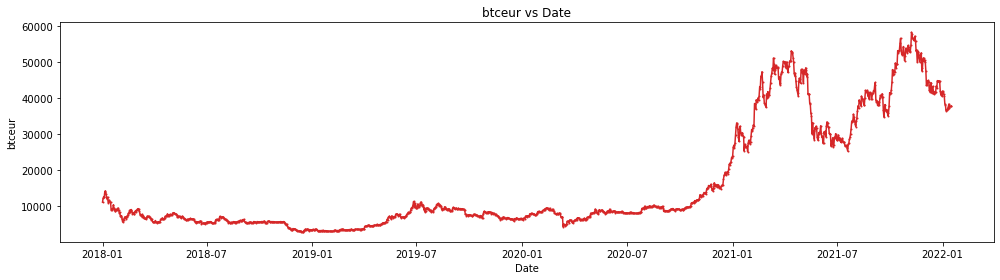

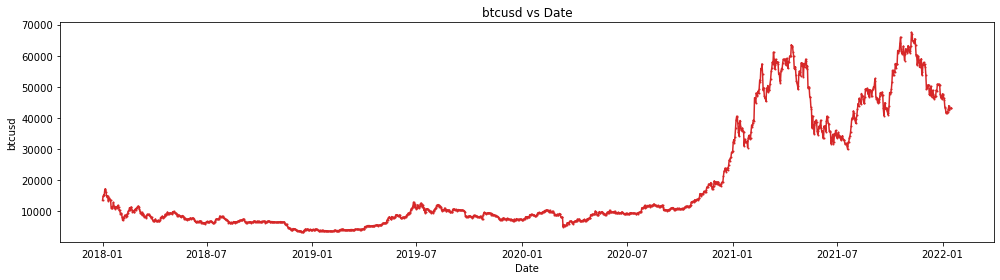

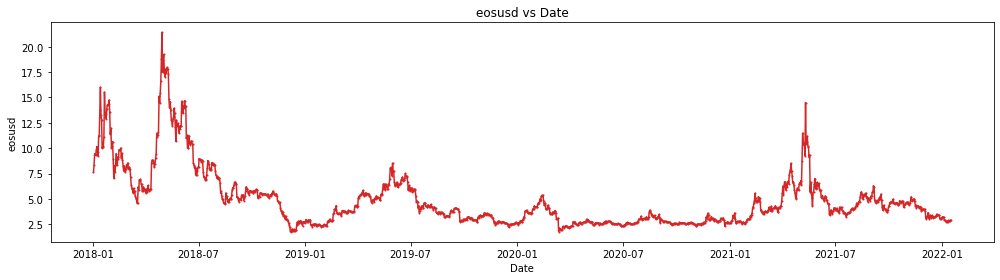

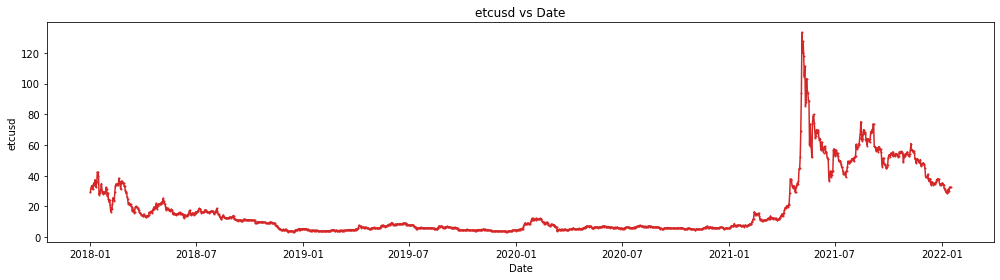

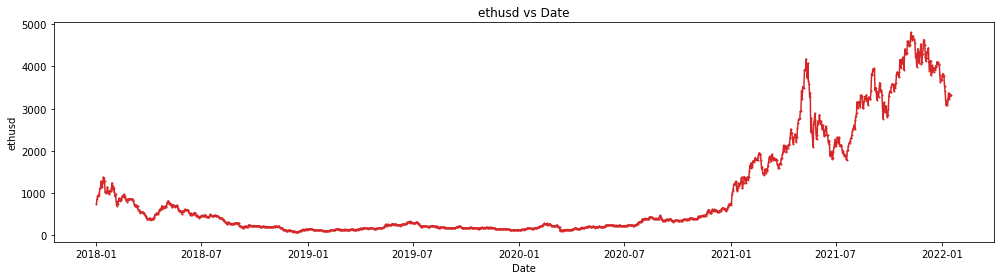

In [10]:
//Plot daily price chart for all the selected cryptocurrency pairs
plotCryptoDaily[;2018.01.01;.z.D] each 5#syms;

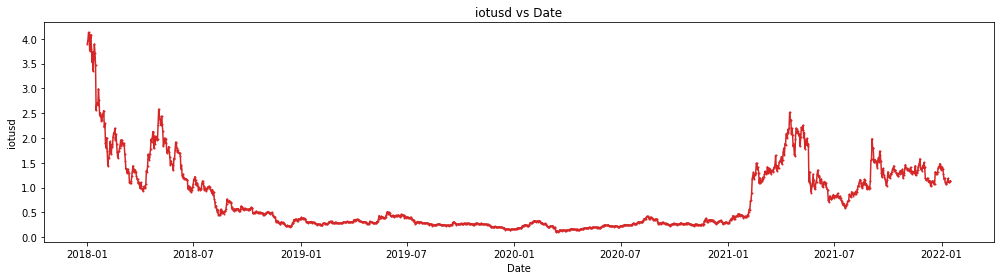

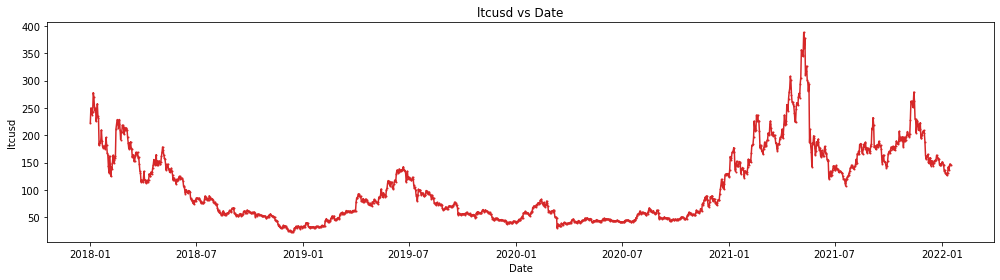

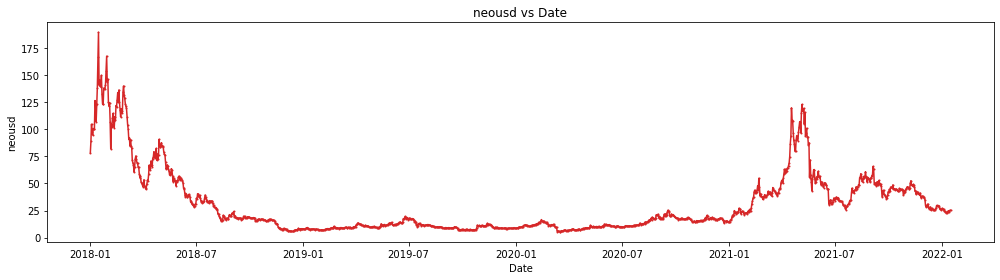

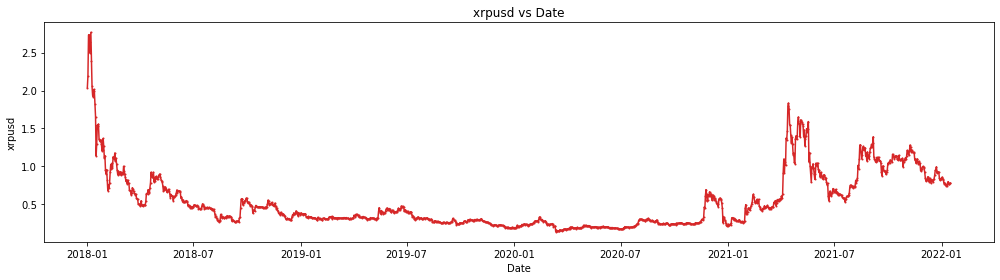

In [11]:
plotCryptoDaily[;2018.01.01;.z.D] each -4#syms;

## Data Exploration for period Jan 2018 to Dec 2019 ##

### Cross correlation ###

In [12]:
getDailyReturn:{[symbol;sd;ed] 
    data:select from dailyTbl where date within (sd;ed), sym=symbol;
    data:update ret1d:log[close%prev close] from data;
    data:`date xkey (`date;symbol) xcol select date, ret1d from data;
    :1_data;};

In [13]:
computeCrossCorr:{[syms;sd;ed]
    retTbl:(lj/)getDailyReturn[;sd;ed] each syms;
    cyptocorr:r cor/:\:r:(enlist `date) _flip 0!retTbl;
    cyptocorr:`sym xkey update sym: key cyptocorr from value flip cyptocorr;
    :cyptocorr;};

#### year 2018: Cross correlation of daily return   ####

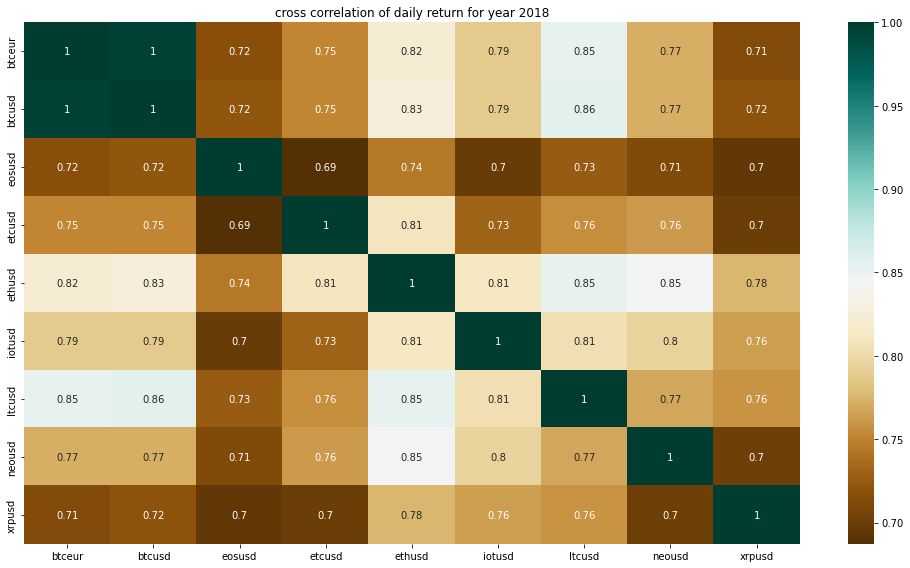

In [14]:
cyptocorr:computeCrossCorr[syms;2018.01.01;2018.12.31];
.util.plotHeatMap[cyptocorr;"cross correlation of daily return for year 2018"];

#### year 2019: Cross correlation of daily return   ####

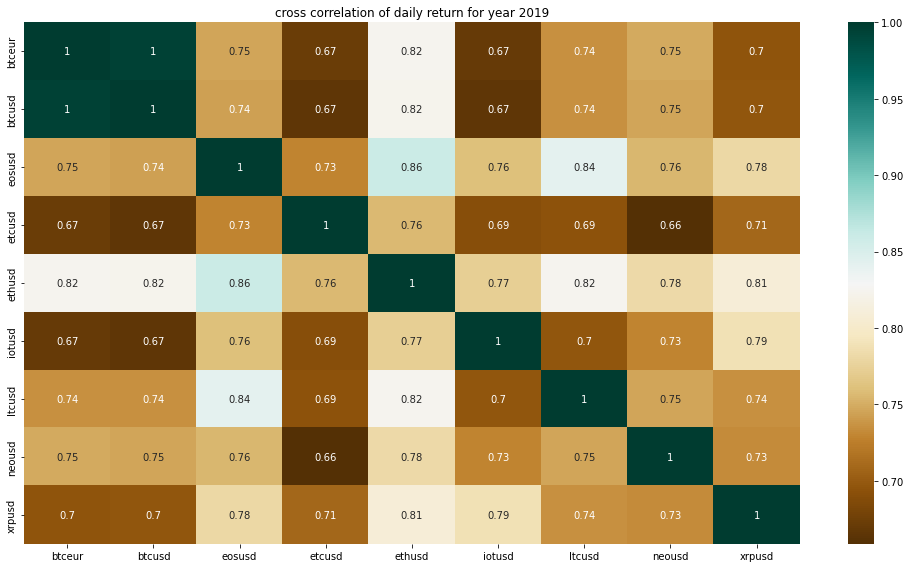

In [15]:
cyptocorr:computeCrossCorr[syms;2019.01.01;2019.12.31];
.util.plotHeatMap[cyptocorr;"cross correlation of daily return for year 2019"];

##### Observation: ######
 The highest cross-correlations are observed for the following pairs:
 1. btcusd vs btceur: (2018: 0.95; 2019: 0.94) This is driven by correlation between usd and eur. We are not interested in cross currency pair.
 2. btcsd vs ethusd: (2018: 0.77; 2019:0.72)
 3. btcusd vs itcusd:(2018: 0.75; 2019:0.62)
 4. btceur vs ethusd (2018: 0.74; 2019:0.69): cross currency pair
 5. btceur vs itcusd (2018: 0.73; 2019:0.59): cross currency pair
 6. etcusd vs itcusd (2018: 0.72; 2019:0.67)
 7. btcusd vs xrpusd (2018: 0.68; 2019:0.56)
 8. ethusd vs eosusd (2018: 0.67; 2019:0.68)
 9. btcusd vs eosusd (2018: 0.67; 2019:0.62)
 10. xrpusd vs ethusd (2018: 0.66; 2019:0.60)

### Auto correlation of daily return ###

##### Observation: ######
We observed significant auto correlation (ACF) and partial auto correlation in the 5 minute return data. So, we switched to hourly returns to estimate number of lags. Following charts show that the significant ACF and PACF exist for lags beyond 24 hours.

In [16]:
retTbl:(lj/)getDailyReturn[;2018.01.01;2018.12.31] each syms;
retTbl:(enlist `date) _flip 0!retTbl;

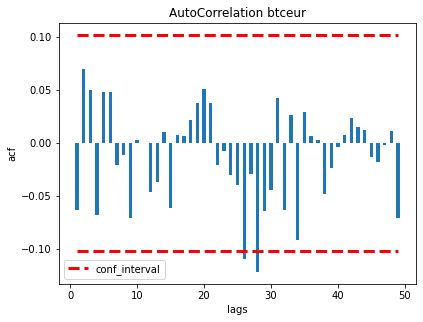

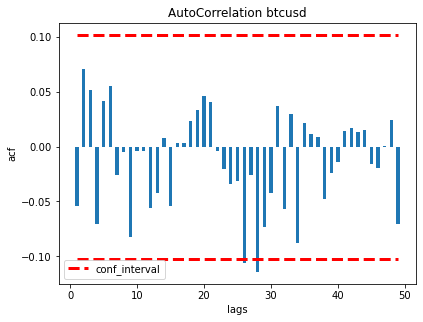

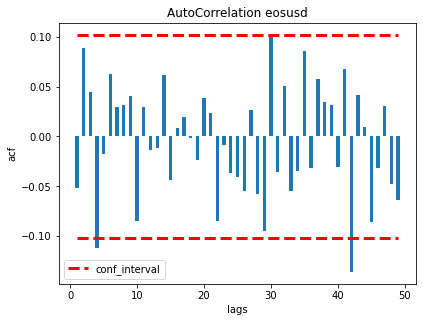

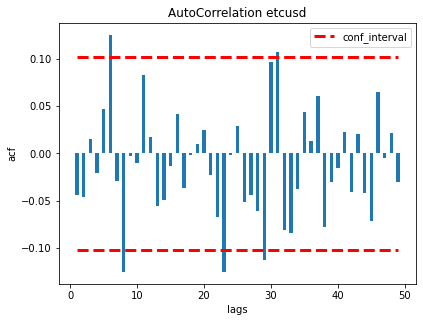

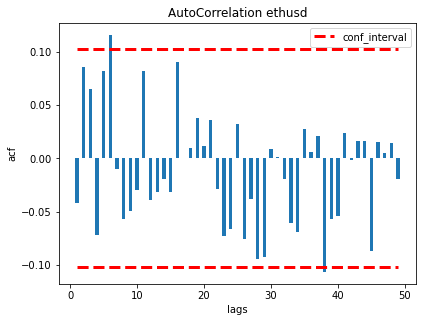

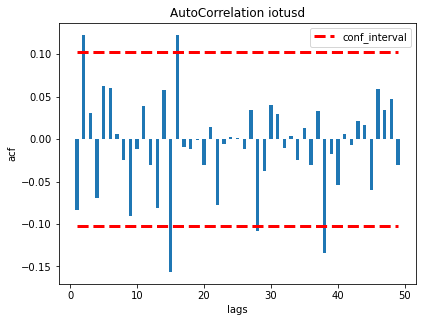

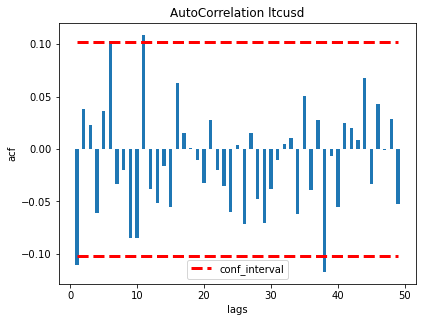

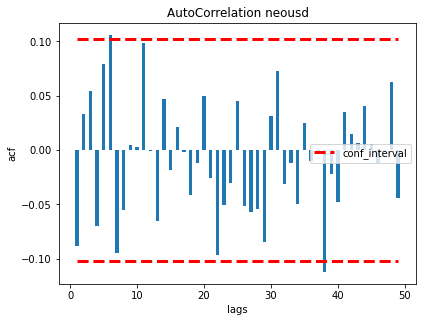

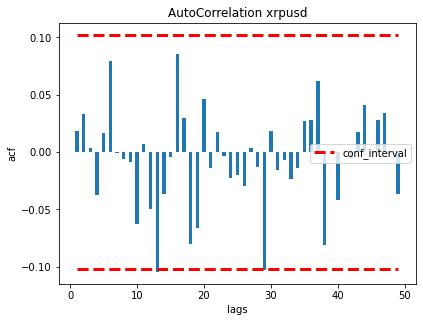

In [17]:
{.ml.ts.acfPlot[retTbl x;50;1; string[x]]} each syms;

### Partial Auto correlation of daily return ###

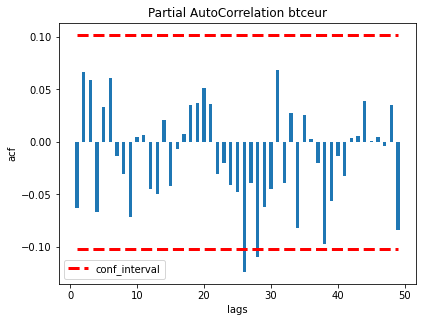

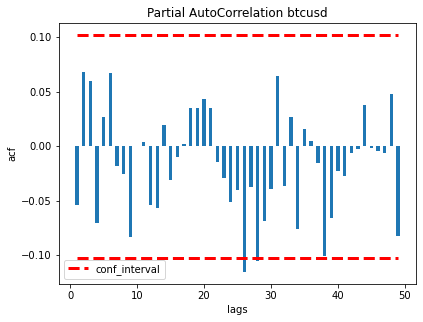

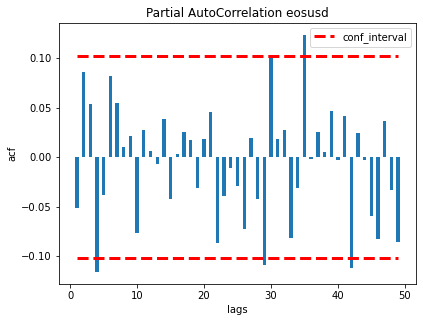

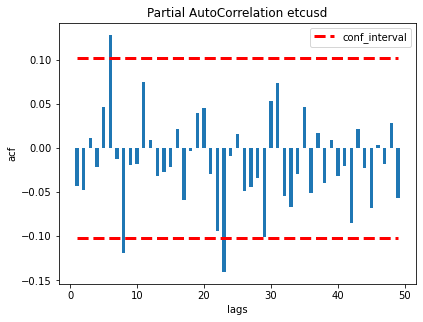

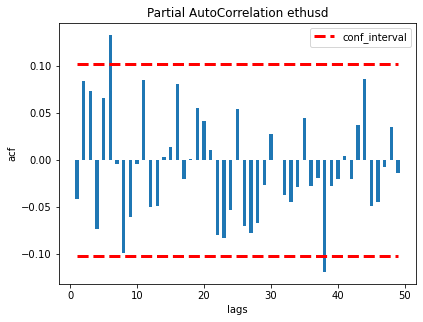

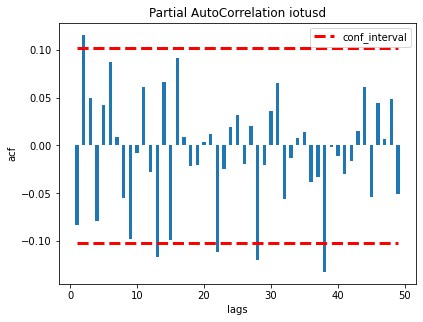

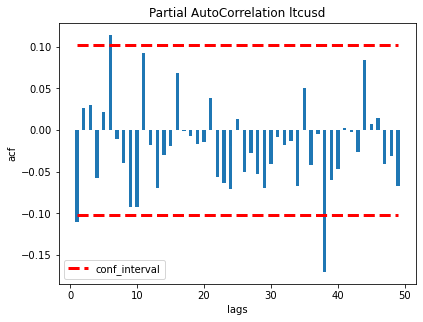

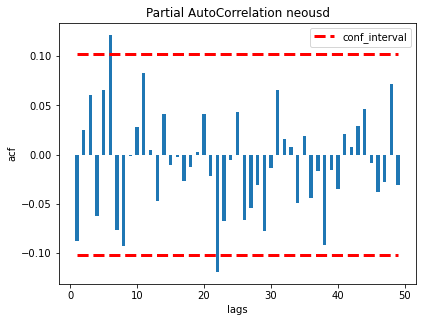

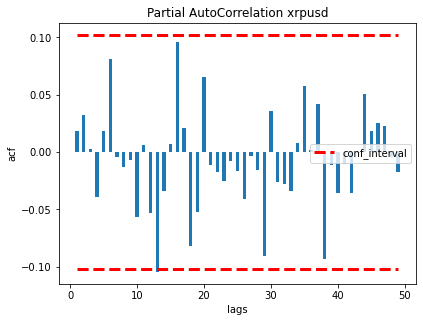

In [18]:
{.ml.ts.pacfPlot[retTbl x;50;1; string[x]]} each syms;

### Model proposal and estimation ###

In [213]:
// @functionoverview Generates forward 1-day return for specified symbol within start date and end date
// @param symbol {symbol} cryptocurrency symbol
// @param sd {date} start date 
// @param ed {date} end date 
// @returns {tbl} table containing 1-day return keyed by sym and date 
generateTargetData:{[symbol;sd;ed]
  data:select from dailyTbl where sym=symbol;
  data:select sym:symbol, date, retfwd:log xprev[neg 1;close]%close, targetcol:log xprev[neg 1;close]%close from data;
  data:select from data where not null retfwd;
  data:select from data where date within (sd;ed);
  data: `sym`date xkey data;
  :data;};

In [214]:
// @functionoverview Generates classification based on targetcol in the input tbl
// @param targetTbl {tbl} table containing target column
// @returns {tbl} updated input table with classification column 
generateUpDownClassification:{[targetTbl]
 :update class:?[targetcol>0;1;0] from targetTbl;};

In [215]:
// @functionoverview Generates classification based on targetcol in the input tbl
// @param targetTbl {tbl} table containing target column
// @returns {tbl} updated input table with classification column 
generateCrossSectionalClassification:{[targetTbl]
 toprank: -1 + floor 0.8*count syms;
 :update class:?[toprank < rank targetcol;1;0] by date from targetTbl;};

In [216]:
// @functionoverview Generates feature set for specified symbol wthin start date and end date
// @param symbol {symbol} cryptocurrency symbol
// @param sd {date} start date 
// @param ed {date} end date 
// @returns {tbl} table containing momentum, volatility, volume, turnover features keyed by sym and date 
generateFeaturesData:{[symbol;sd;ed]
  // select price and volume data for the specified symbol
  data:select from dailyTbl where sym=symbol;

  // Add returns for 1,5,10,20,60,120 days
  data:update ret1: (log close%xprev[1;close]),
    ret5:(log close%xprev[5;close]),
    ret10:(log close%xprev[10;close]),
    ret20:(log close%xprev[20;close]),
    ret40:(log close%xprev[40;close]),
    ret60:(log close%xprev[60;close]),
    ret120:(log close%xprev[120;close]) from data;

  // Add 1-day return volatilities for 10,20,40,60,120 days
  data:update std10:mdev[10;ret1], 
    std20:mdev[20;ret1], 
    std40:mdev[40;ret1],
    std60:mdev[60;ret1],
    std120:mdev[120;ret1] from data;

  // Add volume acceleration features
  data:update volumeratio:volume%mavg[20;volume],
    volume20ratio:mavg[20;volume]%mavg[40;volume],
    volume40ratio:mavg[40;volume]%mavg[60;volume],
    volume60ratio:mavg[60;volume]%mavg[120;volume] from data;

  // Add avg turnover 
  data:update turnover20:mavg[20;volume*close],
    turnover40:mavg[60;volume*close],
    turnover60:mavg[80;volume*close],
    turnover120:mavg[120;volume*close] from data;

  //Add volume volatility
  data:update stdvolume20:mdev[20;volume], 
    stdvolume40:mdev[40;volume],
    stdvolume60:mdev[60;volume],
    stdvolume120:mdev[120;volume] from data;
  
  // remove days with null feature values
  data:select from data where not null ret120, not null std120, not null volume60ratio, not null turnover120, not null stdvolume120;
  
  // select dates within the start date and end date range
  data:select from data where date within (sd;ed);

  // Remove all the columns (price and volume) except feature columns
  data:delete open, close, high, low, volume from data;

  // Add sym and date key
  data:`sym`date xkey data;
  :data;};

In [217]:
// @functionoverview Generates dict containing target and feature tabls for both traning and testing set
// @param data {tbl} table containing target and feature columns
// @param splitdt {date} split date for training and testing split
// @returns {dict} returns dict containing target and feature tabls for both traning and testing set
trainTestSplit: {[data;splitdt]
    // Generate training data using date < split date
    trainData:select from data where date < splitdt;
    // delete all columns except feature columns
    xtrain: delete sym, date, retfwd, targetcol, class from trainData;
    xtrain: flip value flip xtrain;
    // populate target with classification
    ytrain: select class from trainData;
    show select count i by class from ytrain;
    ytrain: flip value flip ytrain;
    
     // Generate testing data using date >= split date
    testData:select from data where date >= splitdt;
    // delete all columns except feature columns
    xtest: delete sym, date, retfwd, targetcol, class from testData;
    xtest: flip value flip xtest;
    // populate target with classification
    ytest: select class from testData;
    show select count i by class from ytest;
    ytest: flip value flip ytest;

    //return dictionary containing training and testing data
    :(`xtrain`ytrain`xtest`ytest)!(xtrain;ytrain;xtest;ytest);};

In [218]:
// @functionoverview Generates score for performance comparison for various models
// @param yact {list} actual value of target 
// @param ypred {list} predicted value of target 
// @param yprob {list} probability of all classification 
// @returns {dict} returns dict containing log loss score, accuracy score and roc auc score
score:{[yact;ypred;yprob]
 `loss`acc`auc!(last .ml.logLoss[yact;yprob];last .ml.accuracy[ypred;yact];.ml.rocAucScore[raze yact;yprob[;1]])};

In [219]:
generateSignal:{[syms;sd;ed;trainingDays]
    // Compute training start date starting from 2018.01.01
    trnsd: 2018.01.01|sd-trainingDays;
    
    // Print training and testing periods
    -1 "::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::";
    -1 "Training Start Date: ", string[trnsd], " ", "Trading End Date: ", string[sd-1];
    -1 "Testing Start Date: ", string[sd], " ", "Testing End Date: ", string[ed];
    // Generate target data for all the cyptocurrency
    targetData: (uj/) generateTargetData[;trnsd;ed] each syms;

    // Generate classification based on the target feature is postive or negative
    //targetData: generateUpDownClassification[targetData];
    targetData: generateCrossSectionalClassification[targetData];

    // Generate features data
    featureData: (uj/)generateFeaturesData[;trnsd;ed] each syms;
    
    // remove dates if not present in both target tbl or features tbl
    data:0!ij[targetData;featureData];
    
    //generate training and testing data
    -1 "Training and testing row count: ";
    datadict:trainTestSplit[data;sd];
    show count each datadict;

    //Random forest classifier setting
    name:"Random Forest Classifier";
    ntrees:100;
    clfkwargs:`class_weight`max_depth!(`balanced;5);
    clf:.p.import[`sklearn.ensemble]`:RandomForestClassifier;
    clf:clf[`n_estimators pykw ntrees;pykwargs clfkwargs];
 
    //Random forest fit
    clf[`:fit][xnp:.util.npa datadict`xtrain;datadict`ytrain];
    
    //Probability estimation
    ytrnprob:clf[`:predict_proba;<;xnp];
    ytrnpred:{x?max x} each ytrnprob;
    ytstprob:clf[`:predict_proba;<;.util.npa datadict`xtest];
    ytstpred:{x?max x} each ytstprob;
    
    //Genrate model performance score
    trnscore:score[datadict`ytrain;ytrnpred;ytrnprob];
    tstscore:score[datadict`ytest ;ytstpred;ytstprob];
    
    //Show feature importance
    -1"\n",":Top 10 features:";
    featurecolnames:(cols featureData) except `sym`date;
    show 10#desc (feature:featurecolnames)!(importance:clf[`:feature_importances_]`);
    
    .util.displayROC[raze datadict`ytest;ytstprob[;1]];
    -1 name," (",string[ntrees]," trees)";
    -1 "Training log loss: ",string[trnscore`loss],", accuracy: ",string[trnscore`acc],", ROC: ",string trnscore`auc;
    -1 "Testing  log loss: ",string[tstscore`loss],", accuracy: ",string[tstscore`acc],", ROC: ",string tstscore`auc;
    -1"\n";
    
    signalData: `date`sym xkey select date, sym,  retfwd, probUp:ytstprob[;1] from data where sd <=date;

    :signalData;};


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.01.01 Trading End Date: 2018.12.31
Testing Start Date: 2019.01.01 Testing End Date: 2019.01.31
Training and testing row count: 
class| x   
-----| ----
0    | 2553
1    | 728 
class| x  
-----| ---
0    | 217
1    | 62 
xtrain| 3281
ytrain| 3281
xtest | 279
ytest | 279

:Top 10 features:
std120     | 0.05925003
ret1       | 0.05505028
stdvolume60| 0.0550151
stdvolume20| 0.05441916
std10      | 0.05318986
ret40      | 0.05301001
std60      | 0.04964128
ret120     | 0.04940774
turnover120| 0.04742637
stdvolume40| 0.04666179


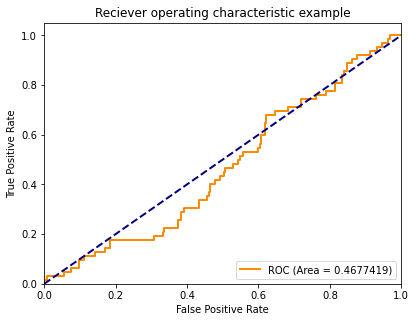

Random Forest Classifier (100 trees)
Training log loss: 0.6256845, accuracy: 0.7223407, ROC: 0.7729756
Testing  log loss: 0.6683817, accuracy: 0.5878136, ROC: 0.4677419


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.02.01 Trading End Date: 2019.01.31
Testing Start Date: 2019.02.01 Testing End Date: 2019.02.28
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 196
1    | 56 
xtrain| 3285
ytrain| 3285
xtest | 252
ytest | 252

:Top 10 features:
std60       | 0.06070097
std20       | 0.0568587
std10       | 0.05351418
ret120      | 0.05034559
std120      | 0.04937822
stdvolume20 | 0.04886775
ret40       | 0.0463288
ret1        | 0.04467783
stdvolume120| 0.04410601
ret60       | 0.0438577


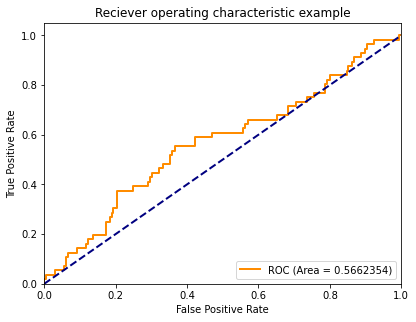

Random Forest Classifier (100 trees)
Training log loss: 0.6275104, accuracy: 0.7327245, ROC: 0.7737879
Testing  log loss: 0.655899, accuracy: 0.6904762, ROC: 0.5662354


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.03.01 Trading End Date: 2019.02.28
Testing Start Date: 2019.03.01 Testing End Date: 2019.03.31
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 217
1    | 62 
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
std10        | 0.05945461
stdvolume20  | 0.05452618
ret40        | 0.05247757
ret60        | 0.05176328
std20        | 0.05049106
std120       | 0.04633572
volume60ratio| 0.04604452
turnover60   | 0.04312008
volumeratio  | 0.04264018
std40        | 0.04263412


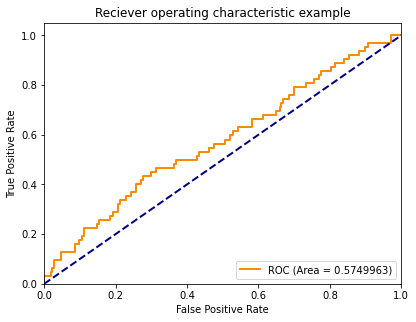

Random Forest Classifier (100 trees)
Training log loss: 0.6239296, accuracy: 0.7543379, ROC: 0.785102
Testing  log loss: 0.6522867, accuracy: 0.6702509, ROC: 0.5749963


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.04.01 Trading End Date: 2019.03.31
Testing Start Date: 2019.04.01 Testing End Date: 2019.04.30
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 210
1    | 60 
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret60        | 0.06412664
std60        | 0.0582109
ret1         | 0.05265264
std120       | 0.04923104
turnover120  | 0.04857951
ret120       | 0.04852607
ret40        | 0.04821963
stdvolume120 | 0.04572276
volume60ratio| 0.04459695
stdvolume60  | 0.04313546


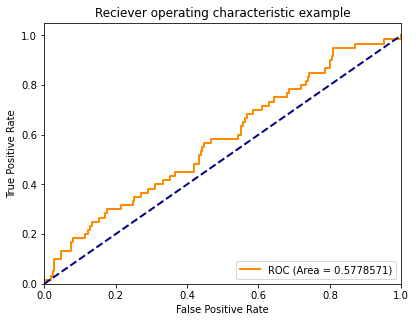

Random Forest Classifier (100 trees)
Training log loss: 0.6201034, accuracy: 0.7421613, ROC: 0.7782484
Testing  log loss: 0.6674005, accuracy: 0.6592593, ROC: 0.5778571


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.05.01 Trading End Date: 2019.04.30
Testing Start Date: 2019.05.01 Testing End Date: 2019.05.31
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 217
1    | 62 
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
std60      | 0.06895429
std120     | 0.06772239
ret60      | 0.0635844
ret40      | 0.05408907
stdvolume20| 0.05234228
stdvolume40| 0.04600214
std40      | 0.045743
ret1       | 0.04544721
stdvolume60| 0.04344296
ret20      | 0.04313353


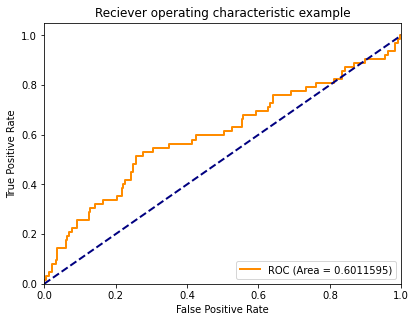

Random Forest Classifier (100 trees)
Training log loss: 0.6174617, accuracy: 0.7305936, ROC: 0.7795813
Testing  log loss: 0.6369812, accuracy: 0.688172, ROC: 0.6011595


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.06.01 Trading End Date: 2019.05.31
Testing Start Date: 2019.06.01 Testing End Date: 2019.06.30
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 210
1    | 60 
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
std120      | 0.07520741
std60       | 0.06621713
ret60       | 0.05273043
ret1        | 0.05196002
ret40       | 0.04868541
std40       | 0.04583098
stdvolume40 | 0.04551391
turnover120 | 0.04431984
stdvolume120| 0.0439773
stdvolume60 | 0.04374877


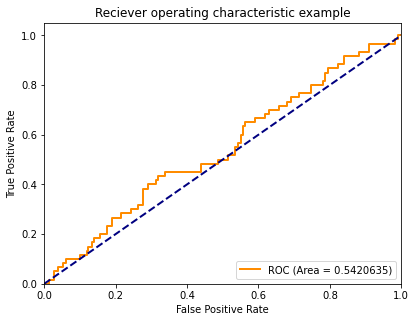

Random Forest Classifier (100 trees)
Training log loss: 0.6158042, accuracy: 0.7400304, ROC: 0.7808155
Testing  log loss: 0.6708821, accuracy: 0.5962963, ROC: 0.5420635


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.07.01 Trading End Date: 2019.06.30
Testing Start Date: 2019.07.01 Testing End Date: 2019.07.31
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 217
1    | 62 
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
std120       | 0.06588313
std60        | 0.06301366
ret40        | 0.06148025
stdvolume120 | 0.05339888
volume60ratio| 0.04877224
stdvolume60  | 0.04626153
ret60        | 0.04463174
ret20        | 0.04373176
ret5         | 0.04159898
ret1         | 0.04140631


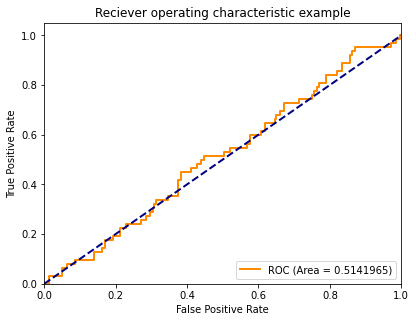

Random Forest Classifier (100 trees)
Training log loss: 0.6175429, accuracy: 0.7315068, ROC: 0.7789631
Testing  log loss: 0.6409115, accuracy: 0.7240143, ROC: 0.5141965


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.08.01 Trading End Date: 2019.07.31
Testing Start Date: 2019.08.01 Testing End Date: 2019.08.31
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 217
1    | 62 
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
std120       | 0.06162493
ret40        | 0.06139794
std60        | 0.05471363
stdvolume120 | 0.05300089
stdvolume60  | 0.04947634
volumeratio  | 0.04912979
volume60ratio| 0.0487006
ret120       | 0.04664606
stdvolume40  | 0.04436998
ret1         | 0.04343088


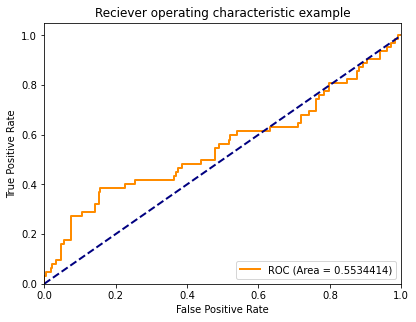

Random Forest Classifier (100 trees)
Training log loss: 0.6248204, accuracy: 0.7412481, ROC: 0.7693858
Testing  log loss: 0.6311128, accuracy: 0.734767, ROC: 0.5534414


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.09.01 Trading End Date: 2019.08.31
Testing Start Date: 2019.09.01 Testing End Date: 2019.09.30
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 210
1    | 60 
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret1         | 0.05747343
std120       | 0.05631411
ret40        | 0.05275045
std60        | 0.0519023
stdvolume120 | 0.05172262
std10        | 0.0495799
stdvolume60  | 0.04877636
volume60ratio| 0.04877542
volumeratio  | 0.04723405
ret60        | 0.04424092


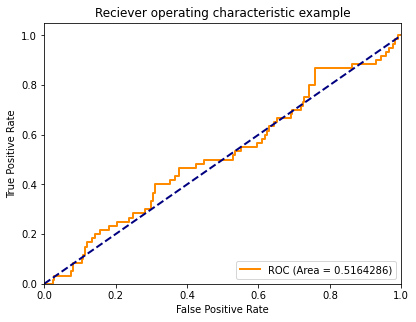

Random Forest Classifier (100 trees)
Training log loss: 0.6220078, accuracy: 0.7844749, ROC: 0.7905128
Testing  log loss: 0.6472136, accuracy: 0.7148148, ROC: 0.5164286


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.10.01 Trading End Date: 2019.09.30
Testing Start Date: 2019.10.01 Testing End Date: 2019.10.31
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 217
1    | 62 
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret60       | 0.06585469
std120      | 0.05688369
volumeratio | 0.05397047
stdvolume60 | 0.05002815
stdvolume120| 0.04764296
std60       | 0.04637507
ret40       | 0.04452171
ret1        | 0.0440184
turnover60  | 0.04337297
stdvolume20 | 0.0430745


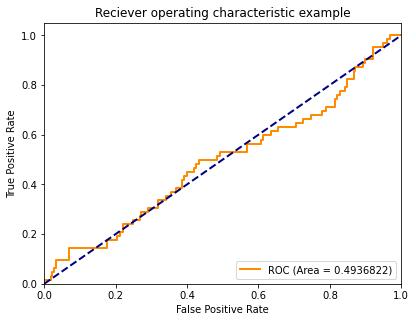

Random Forest Classifier (100 trees)
Training log loss: 0.6198208, accuracy: 0.7872146, ROC: 0.8007608
Testing  log loss: 0.6465502, accuracy: 0.7526882, ROC: 0.4936822


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.11.01 Trading End Date: 2019.10.31
Testing Start Date: 2019.11.01 Testing End Date: 2019.11.30
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 210
1    | 60 
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
volumeratio  | 0.06274338
ret40        | 0.05671539
ret20        | 0.05165797
volume40ratio| 0.0489391
ret120       | 0.04871077
ret60        | 0.04824133
std120       | 0.04574698
std60        | 0.04432091
std10        | 0.04348903
stdvolume20  | 0.04290142


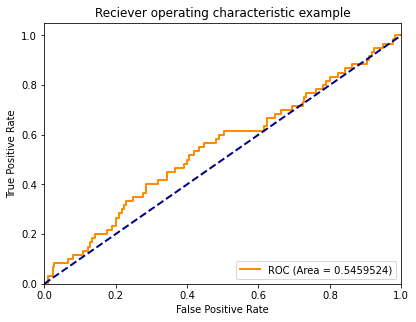

Random Forest Classifier (100 trees)
Training log loss: 0.6241675, accuracy: 0.7951294, ROC: 0.8233579
Testing  log loss: 0.6565705, accuracy: 0.7111111, ROC: 0.5459524


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.12.01 Trading End Date: 2019.11.30
Testing Start Date: 2019.12.01 Testing End Date: 2019.12.31
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 217
1    | 62 
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret120      | 0.06051192
stdvolume120| 0.05926142
volumeratio | 0.0552049
ret40       | 0.05307564
ret20       | 0.04818121
ret10       | 0.04715989
std120      | 0.04542512
std60       | 0.04450354
std40       | 0.04396493
turnover120 | 0.04256616


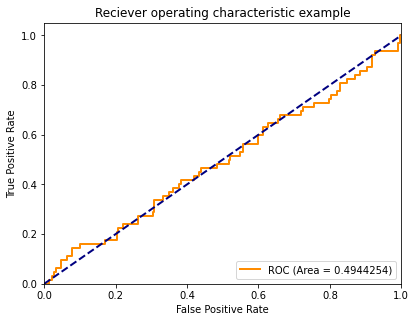

Random Forest Classifier (100 trees)
Training log loss: 0.6189868, accuracy: 0.7978691, ROC: 0.8262976
Testing  log loss: 0.6428092, accuracy: 0.7598566, ROC: 0.4944254


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.01.01 Trading End Date: 2019.12.31
Testing Start Date: 2020.01.01 Testing End Date: 2020.01.31
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 217
1    | 62 
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
stdvolume120 | 0.05671076
volumeratio  | 0.05267461
ret20        | 0.05068511
ret10        | 0.0474296
ret120       | 0.04630994
volume60ratio| 0.04598108
turnover40   | 0.04435815
ret5         | 0.04391889
stdvolume40  | 0.04385797
turnover120  | 0.04351013


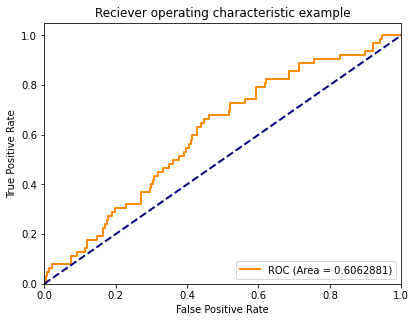

Random Forest Classifier (100 trees)
Training log loss: 0.6206447, accuracy: 0.7765601, ROC: 0.8088969
Testing  log loss: 0.6710289, accuracy: 0.5985663, ROC: 0.6062881


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.02.01 Trading End Date: 2020.01.31
Testing Start Date: 2020.02.01 Testing End Date: 2020.02.29
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 203
1    | 58 
xtrain| 3285
ytrain| 3285
xtest | 261
ytest | 261

:Top 10 features:
volume20ratio| 0.05819648
ret40        | 0.05705277
ret60        | 0.05076383
stdvolume120 | 0.05070172
turnover120  | 0.04792946
std120       | 0.04700468
ret120       | 0.04609034
turnover40   | 0.04479106
ret10        | 0.04451426
ret20        | 0.04251644


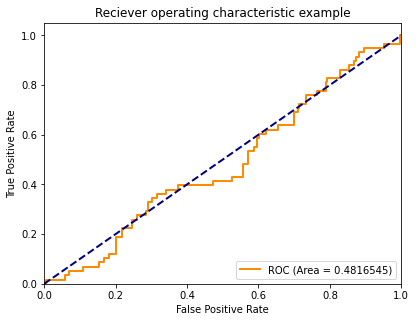

Random Forest Classifier (100 trees)
Training log loss: 0.6198154, accuracy: 0.7808219, ROC: 0.8001962
Testing  log loss: 0.7087674, accuracy: 0.4482759, ROC: 0.4816545


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.03.02 Trading End Date: 2020.02.29
Testing Start Date: 2020.03.01 Testing End Date: 2020.03.31
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 217
1    | 62 
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
volume20ratio| 0.06464056
std120       | 0.05427536
ret120       | 0.05362129
turnover120  | 0.05302132
ret20        | 0.04914862
ret40        | 0.04589331
volumeratio  | 0.04462548
ret10        | 0.04377168
ret5         | 0.04369922
turnover60   | 0.04197367


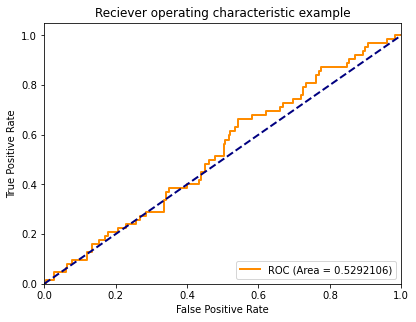

Random Forest Classifier (100 trees)
Training log loss: 0.6207594, accuracy: 0.785997, ROC: 0.8071222
Testing  log loss: 0.6741667, accuracy: 0.5555556, ROC: 0.5292106


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.04.02 Trading End Date: 2020.03.31
Testing Start Date: 2020.04.01 Testing End Date: 2020.04.30
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 210
1    | 60 
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
volume20ratio| 0.0815986
ret20        | 0.05763817
std120       | 0.05663557
turnover60   | 0.0533596
ret120       | 0.05248671
turnover40   | 0.04643128
std40        | 0.04511142
volumeratio  | 0.04183398
ret5         | 0.04051744
volume60ratio| 0.04003271


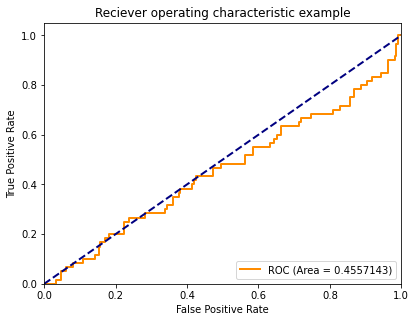

Random Forest Classifier (100 trees)
Training log loss: 0.6217261, accuracy: 0.7936073, ROC: 0.8182682
Testing  log loss: 0.6605586, accuracy: 0.6851852, ROC: 0.4557143


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.05.02 Trading End Date: 2020.04.30
Testing Start Date: 2020.05.01 Testing End Date: 2020.05.31
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 217
1    | 62 
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
volume20ratio| 0.08466383
ret20        | 0.0568809
turnover120  | 0.05065388
std10        | 0.04893626
ret120       | 0.04478814
turnover60   | 0.04448095
volumeratio  | 0.0439625
ret5         | 0.04338234
turnover40   | 0.04293793
ret40        | 0.04178301


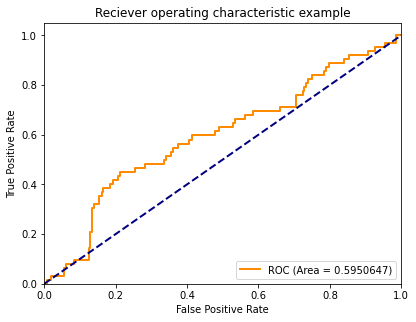

Random Forest Classifier (100 trees)
Training log loss: 0.6244644, accuracy: 0.7987823, ROC: 0.8122285
Testing  log loss: 0.6520127, accuracy: 0.7096774, ROC: 0.5950647


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.06.02 Trading End Date: 2020.05.31
Testing Start Date: 2020.06.01 Testing End Date: 2020.06.30
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 210
1    | 60 
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
volume20ratio| 0.08078374
turnover60   | 0.05482085
turnover40   | 0.05123852
ret20        | 0.05099619
std10        | 0.04945709
volumeratio  | 0.04904841
ret120       | 0.04519736
volume60ratio| 0.04375907
volume40ratio| 0.04257041
stdvolume60  | 0.04209822


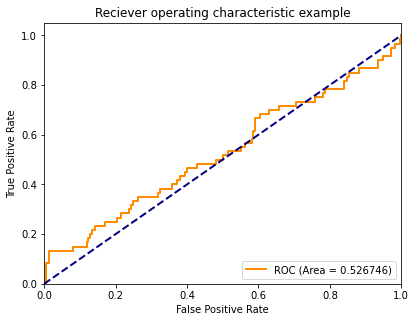

Random Forest Classifier (100 trees)
Training log loss: 0.6235173, accuracy: 0.7777778, ROC: 0.8057454
Testing  log loss: 0.6515302, accuracy: 0.6851852, ROC: 0.526746


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.07.02 Trading End Date: 2020.06.30
Testing Start Date: 2020.07.01 Testing End Date: 2020.07.31
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 217
1    | 62 
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
volume20ratio| 0.07674105
turnover120  | 0.06218192
turnover60   | 0.05535648
ret120       | 0.05377936
ret60        | 0.04717491
ret20        | 0.045356
std40        | 0.04228298
volume40ratio| 0.04125022
ret10        | 0.0407509
stdvolume40  | 0.04011616


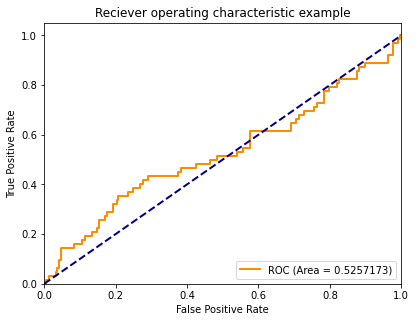

Random Forest Classifier (100 trees)
Training log loss: 0.6239132, accuracy: 0.7780822, ROC: 0.7920789
Testing  log loss: 0.6457546, accuracy: 0.7096774, ROC: 0.5257173


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.08.02 Trading End Date: 2020.07.31
Testing Start Date: 2020.08.01 Testing End Date: 2020.08.31
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 217
1    | 62 
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
volume20ratio| 0.07264059
turnover40   | 0.0548745
ret120       | 0.05438353
stdvolume60  | 0.04920695
turnover120  | 0.04865751
stdvolume20  | 0.04713696
ret10        | 0.04597734
volume40ratio| 0.04367627
ret60        | 0.04321876
turnover60   | 0.04305207


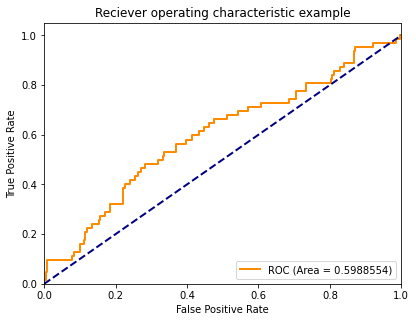

Random Forest Classifier (100 trees)
Training log loss: 0.6241617, accuracy: 0.7683409, ROC: 0.7882932
Testing  log loss: 0.6604169, accuracy: 0.655914, ROC: 0.5988554


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.09.02 Trading End Date: 2020.08.31
Testing Start Date: 2020.09.01 Testing End Date: 2020.09.30
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 210
1    | 60 
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
stdvolume120 | 0.06051184
stdvolume40  | 0.05224759
stdvolume20  | 0.05140351
ret120       | 0.04921623
ret40        | 0.04893647
turnover120  | 0.04620242
ret10        | 0.04567432
std60        | 0.04459211
volume20ratio| 0.04404267
stdvolume60  | 0.04350962


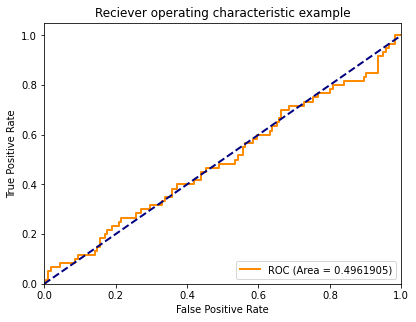

Random Forest Classifier (100 trees)
Training log loss: 0.6212567, accuracy: 0.7722983, ROC: 0.7930697
Testing  log loss: 0.6712616, accuracy: 0.5888889, ROC: 0.4961905


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.10.02 Trading End Date: 2020.09.30
Testing Start Date: 2020.10.01 Testing End Date: 2020.10.31
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 217
1    | 62 
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
turnover120  | 0.06037246
volume20ratio| 0.05278535
stdvolume120 | 0.05091406
stdvolume60  | 0.05022731
volume40ratio| 0.04911582
turnover40   | 0.04824552
turnover60   | 0.04602996
ret120       | 0.04444457
std60        | 0.04397871
stdvolume40  | 0.04324775


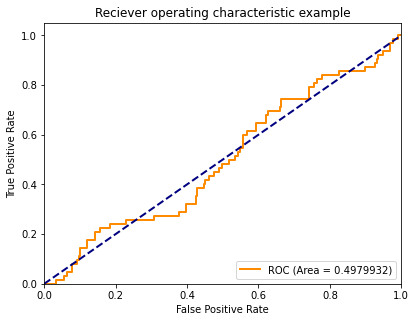

Random Forest Classifier (100 trees)
Training log loss: 0.620778, accuracy: 0.7686454, ROC: 0.7952856
Testing  log loss: 0.6586757, accuracy: 0.702509, ROC: 0.4979932


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.11.02 Trading End Date: 2020.10.31
Testing Start Date: 2020.11.01 Testing End Date: 2020.11.30
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 210
1    | 60 
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
turnover120 | 0.06098935
stdvolume120| 0.05566178
stdvolume60 | 0.05319163
ret120      | 0.05179584
ret40       | 0.05078989
stdvolume20 | 0.04665064
stdvolume40 | 0.04571402
ret60       | 0.04500985
ret10       | 0.0449929
std20       | 0.04466472


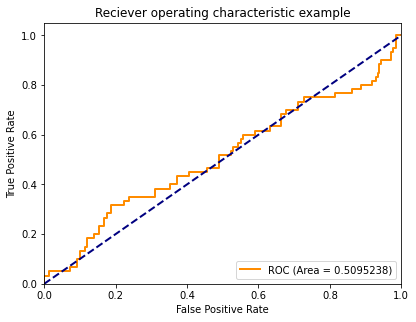

Random Forest Classifier (100 trees)
Training log loss: 0.6223033, accuracy: 0.7634703, ROC: 0.7824491
Testing  log loss: 0.6863765, accuracy: 0.5814815, ROC: 0.5095238


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.12.02 Trading End Date: 2020.11.30
Testing Start Date: 2020.12.01 Testing End Date: 2020.12.31
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 217
1    | 62 
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
turnover120  | 0.06281045
ret40        | 0.0563699
ret10        | 0.05203427
stdvolume120 | 0.04972423
ret20        | 0.04935658
volume40ratio| 0.047806
stdvolume60  | 0.04404827
std40        | 0.04335133
stdvolume20  | 0.04224251
ret60        | 0.04219655


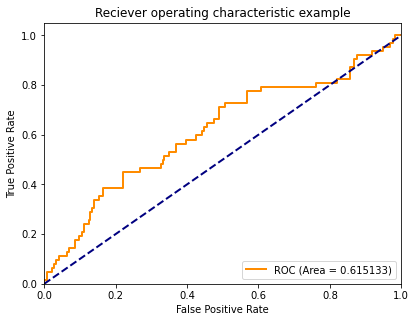

Random Forest Classifier (100 trees)
Training log loss: 0.6197115, accuracy: 0.7762557, ROC: 0.7990993
Testing  log loss: 0.6704052, accuracy: 0.609319, ROC: 0.615133


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.01.02 Trading End Date: 2020.12.31
Testing Start Date: 2021.01.01 Testing End Date: 2021.01.31
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 217
1    | 62 
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret60        | 0.07128306
turnover120  | 0.05819043
ret40        | 0.05753177
volume40ratio| 0.04798242
ret120       | 0.04665482
stdvolume120 | 0.0441764
ret20        | 0.04344652
ret5         | 0.04270121
stdvolume40  | 0.04246043
ret10        | 0.04187712


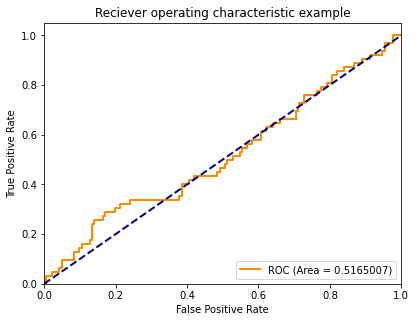

Random Forest Classifier (100 trees)
Training log loss: 0.6181319, accuracy: 0.7722983, ROC: 0.7941458
Testing  log loss: 0.6688471, accuracy: 0.688172, ROC: 0.5165007


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.02.02 Trading End Date: 2021.01.31
Testing Start Date: 2021.02.01 Testing End Date: 2021.02.28
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 196
1    | 56 
xtrain| 3285
ytrain| 3285
xtest | 252
ytest | 252

:Top 10 features:
ret20        | 0.05057128
ret60        | 0.04939479
ret10        | 0.04853662
turnover120  | 0.04731716
ret120       | 0.04712786
stdvolume40  | 0.04593944
turnover40   | 0.04564014
ret40        | 0.04479398
volume40ratio| 0.04445184
ret5         | 0.04326411


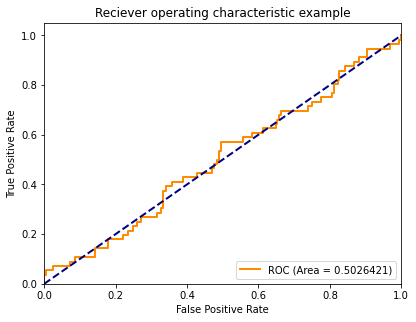

Random Forest Classifier (100 trees)
Training log loss: 0.622682, accuracy: 0.7838661, ROC: 0.8065249
Testing  log loss: 0.6730899, accuracy: 0.6269841, ROC: 0.5026421


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.03.01 Trading End Date: 2021.02.28
Testing Start Date: 2021.03.01 Testing End Date: 2021.03.31
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 217
1    | 62 
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
volume20ratio| 0.0497619
ret20        | 0.04915348
ret10        | 0.04850667
volume40ratio| 0.04712459
std40        | 0.04628586
ret120       | 0.04508079
ret60        | 0.0449679
stdvolume120 | 0.04464123
stdvolume40  | 0.0442441
turnover120  | 0.04419116


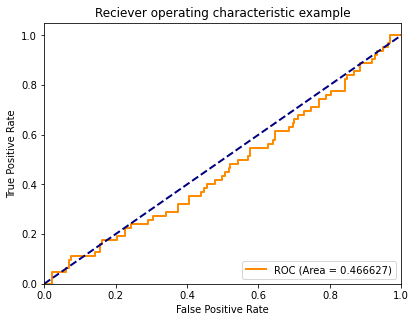

Random Forest Classifier (100 trees)
Training log loss: 0.619826, accuracy: 0.7869102, ROC: 0.8091392
Testing  log loss: 0.6737918, accuracy: 0.609319, ROC: 0.466627


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.04.01 Trading End Date: 2021.03.31
Testing Start Date: 2021.04.01 Testing End Date: 2021.04.30
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 210
1    | 60 
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
stdvolume120| 0.05097547
ret60       | 0.05063561
ret1        | 0.04785396
ret10       | 0.047497
ret20       | 0.04705703
turnover40  | 0.04645134
ret5        | 0.04528602
ret120      | 0.04391242
turnover120 | 0.04388277
std20       | 0.04379972


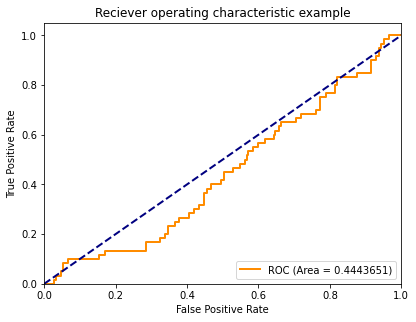

Random Forest Classifier (100 trees)
Training log loss: 0.6189317, accuracy: 0.7817352, ROC: 0.8052516
Testing  log loss: 0.6567984, accuracy: 0.6962963, ROC: 0.4443651


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.05.01 Trading End Date: 2021.04.30
Testing Start Date: 2021.05.01 Testing End Date: 2021.05.31
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 217
1    | 62 
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret60        | 0.06753659
stdvolume120 | 0.05317168
turnover120  | 0.05201851
ret10        | 0.04870969
turnover60   | 0.04760883
ret40        | 0.04654895
ret20        | 0.04553912
std120       | 0.04459479
volume60ratio| 0.04411446
turnover40   | 0.04387675


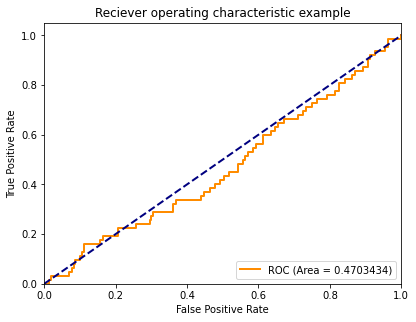

Random Forest Classifier (100 trees)
Training log loss: 0.622144, accuracy: 0.7792998, ROC: 0.8045752
Testing  log loss: 0.6734073, accuracy: 0.6523297, ROC: 0.4703434


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.06.01 Trading End Date: 2021.05.31
Testing Start Date: 2021.06.01 Testing End Date: 2021.06.30
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 210
1    | 60 
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret60        | 0.07396042
ret20        | 0.05683062
turnover120  | 0.05583169
ret10        | 0.05320943
std120       | 0.0505133
stdvolume40  | 0.04373142
ret40        | 0.04310359
ret120       | 0.0430007
ret5         | 0.0424839
volume20ratio| 0.04133869


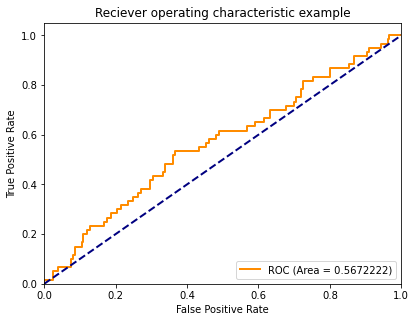

Random Forest Classifier (100 trees)
Training log loss: 0.6234483, accuracy: 0.7884323, ROC: 0.8064156
Testing  log loss: 0.6576018, accuracy: 0.7259259, ROC: 0.5672222


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.07.01 Trading End Date: 2021.06.30
Testing Start Date: 2021.07.01 Testing End Date: 2021.07.31
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 217
1    | 62 
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret20        | 0.05500273
turnover40   | 0.0520372
ret120       | 0.05181963
ret40        | 0.05170924
ret60        | 0.04978106
volume60ratio| 0.04726538
stdvolume120 | 0.04684144
std60        | 0.04682084
volume20ratio| 0.04495416
ret10        | 0.04293128


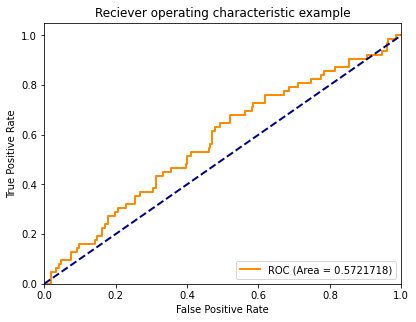

Random Forest Classifier (100 trees)
Training log loss: 0.625875, accuracy: 0.7607306, ROC: 0.7965333
Testing  log loss: 0.6554554, accuracy: 0.702509, ROC: 0.5721718


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.08.01 Trading End Date: 2021.07.31
Testing Start Date: 2021.08.01 Testing End Date: 2021.08.31
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 217
1    | 62 
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
stdvolume120 | 0.05747415
ret40        | 0.0570038
stdvolume60  | 0.0511234
turnover40   | 0.04855383
volume20ratio| 0.04838254
std120       | 0.04763424
ret20        | 0.04647904
ret10        | 0.04624309
ret5         | 0.04582848
ret1         | 0.045587


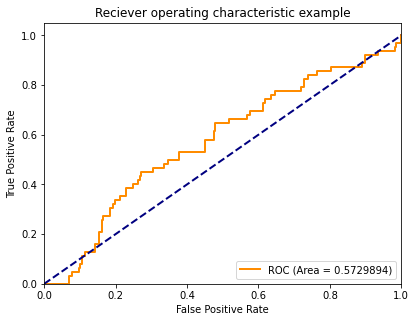

Random Forest Classifier (100 trees)
Training log loss: 0.6254236, accuracy: 0.7710807, ROC: 0.7990306
Testing  log loss: 0.6712556, accuracy: 0.6953405, ROC: 0.5729894


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.09.01 Trading End Date: 2021.08.31
Testing Start Date: 2021.09.01 Testing End Date: 2021.09.30
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 210
1    | 60 
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
stdvolume120 | 0.0535316
stdvolume40  | 0.0514708
turnover120  | 0.05066294
ret60        | 0.04886413
ret40        | 0.04885908
ret20        | 0.04531802
turnover20   | 0.04446921
ret1         | 0.04396949
stdvolume60  | 0.04343841
volume20ratio| 0.04332335


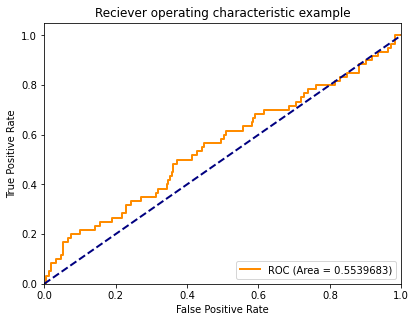

Random Forest Classifier (100 trees)
Training log loss: 0.6215226, accuracy: 0.7722983, ROC: 0.795625
Testing  log loss: 0.6621587, accuracy: 0.6740741, ROC: 0.5539683


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.10.01 Trading End Date: 2021.09.30
Testing Start Date: 2021.10.01 Testing End Date: 2021.10.31
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 217
1    | 62 
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
stdvolume120 | 0.06842527
stdvolume60  | 0.05925491
stdvolume40  | 0.05151449
stdvolume20  | 0.04931492
std20        | 0.04833439
turnover20   | 0.04669463
volume20ratio| 0.04610911
ret20        | 0.04498541
std120       | 0.04306256
turnover60   | 0.04258814


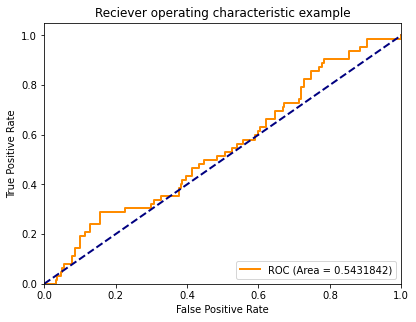

Random Forest Classifier (100 trees)
Training log loss: 0.6216789, accuracy: 0.7613394, ROC: 0.7806219
Testing  log loss: 0.6755641, accuracy: 0.6129032, ROC: 0.5431842


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.11.01 Trading End Date: 2021.10.31
Testing Start Date: 2021.11.01 Testing End Date: 2021.11.30
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 210
1    | 60 
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
stdvolume120| 0.06962673
stdvolume60 | 0.06081115
stdvolume40 | 0.04654405
ret5        | 0.04619486
std120      | 0.04617484
stdvolume20 | 0.0460213
std60       | 0.04566774
ret1        | 0.04538498
volumeratio | 0.04525644
turnover60  | 0.0442464


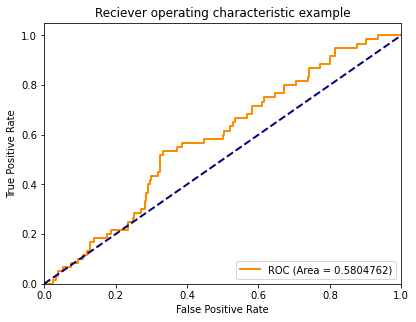

Random Forest Classifier (100 trees)
Training log loss: 0.6247261, accuracy: 0.7643836, ROC: 0.7813136
Testing  log loss: 0.6518984, accuracy: 0.6592593, ROC: 0.5804762


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.12.01 Trading End Date: 2021.11.30
Testing Start Date: 2021.12.01 Testing End Date: 2021.12.31
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 217
1    | 62 
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
stdvolume120| 0.06248841
stdvolume40 | 0.05691767
stdvolume60 | 0.05585978
std120      | 0.04995092
turnover120 | 0.04599712
ret40       | 0.0454062
volumeratio | 0.04455912
ret5        | 0.04447385
ret10       | 0.04256725
ret1        | 0.04074879


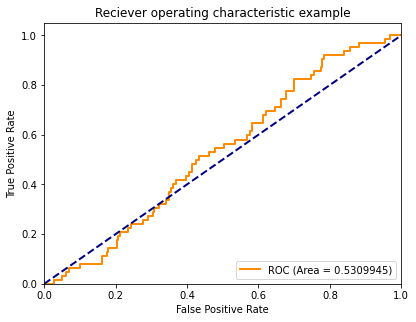

Random Forest Classifier (100 trees)
Training log loss: 0.6238003, accuracy: 0.7701674, ROC: 0.7892558
Testing  log loss: 0.6530884, accuracy: 0.655914, ROC: 0.5309945


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2021.01.01 Trading End Date: 2021.12.31
Testing Start Date: 2022.01.01 Testing End Date: 2022.01.16
Training and testing row count: 
class| x   
-----| ----
0    | 2555
1    | 730 
class| x  
-----| ---
0    | 105
1    | 30 
xtrain| 3285
ytrain| 3285
xtest | 135
ytest | 135

:Top 10 features:
volumeratio | 0.05513071
stdvolume20 | 0.05339445
std120      | 0.05192828
std60       | 0.05077965
turnover60  | 0.04878264
stdvolume60 | 0.04693348
stdvolume40 | 0.04669392
stdvolume120| 0.04619851
ret1        | 0.04608472
turnover120 | 0.04566134


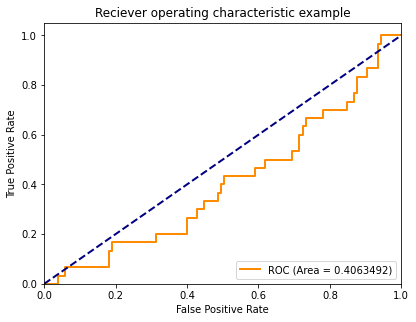

Random Forest Classifier (100 trees)
Training log loss: 0.6294538, accuracy: 0.7488584, ROC: 0.7839402
Testing  log loss: 0.6643427, accuracy: 0.5777778, ROC: 0.4063492




In [220]:
// run backtest to generate signal
backtestTbl: 0!select syms:syms, sd:first date, ed:last date by `month$date, trainingDays:365 from dailyTbl where date >= 2019.01.01;
signalTbl: (uj/) {generateSignal[x[`syms];x[`sd];x[`ed];x[`trainingDays]]} each backtestTbl;

In [189]:
getPnlSummary:{[signalTbl]
    signalTbl:update pos:?[0.52<probUp;1;?[0.48>probUp;-1;0]] by date from signalTbl;
    dailypnlTbl:select totalret:sum pos*retfwd, nassetlong: sum ?[0<pos;1;0], nassetshort: sum ?[pos<0;1;0] by date from signalTbl;
    dailypnlTbl:update nasset: nassetlong + nassetshort from dailypnlTbl;
    dailypnlTbl:update ret: totalret%nasset from dailypnlTbl;
    show select avgret: avg ret, 
        sdret: dev ret, 
        sharperatio: (avg ret)*sqrt(252)%dev ret, 
        minret:min ret, 
        maxret:max ret from dailypnlTbl;
    .util.plotTimeSeriesSubplots[exec date from dailypnlTbl;exec sums ret from dailypnlTbl;"cumulative pnl"];};

In [223]:
getPnlSummary:{[signalTbl]
    toprank: -1 + floor 0.8*count syms;
    bottomrank: -1 + (count syms) - toprank;
    signalTbl:update pos:?[toprank<rank probUp;1;?[bottomrank>rank probUp;-1;0]] by date from signalTbl;
    dailypnlTbl:select totalret:sum pos*retfwd, nassetlong: sum ?[0<pos;1;0], nassetshort: sum ?[pos<0;1;0] by date from signalTbl;
    dailypnlTbl:update nasset: nassetlong + nassetshort from dailypnlTbl;
    dailypnlTbl:update ret: totalret%nasset from dailypnlTbl;
    show dailypnlTbl;
    show select avgret: avg ret, 
        sdret: dev ret, 
        sharperatio: (avg ret)*sqrt(252)%dev ret, 
        minret:min ret, 
        maxret:max ret from dailypnlTbl;
    .util.plotTimeSeriesSubplots[exec date from dailypnlTbl;exec sums ret from dailypnlTbl;"cumulative pnl"];};

date      | totalret     nassetlong nassetshort nasset ret         
----------| -------------------------------------------------------
2019.01.01| 0.09015309   2          2           4      0.02253827  
2019.01.02| -0.0572876   2          2           4      -0.0143219  
2019.01.03| -0.01197154  2          2           4      -0.002992884
2019.01.04| -0.09948838  2          2           4      -0.0248721  
2019.01.05| -0.07563977  2          2           4      -0.01890994 
2019.01.06| 0.01543965   2          2           4      0.003859914 
2019.01.07| 0.01953904   2          2           4      0.00488476  
2019.01.08| 0.07702128   2          2           4      0.01925532  
2019.01.09| -0.05843419  2          2           4      -0.01460855 
2019.01.10| -0.000225124 2          2           4      -5.6281e-005
2019.01.11| -0.005121207 2          2           4      -0.001280302
2019.01.12| -0.06020442  2          2           4      -0.0150511  
2019.01.13| 0.08157912   2          2           

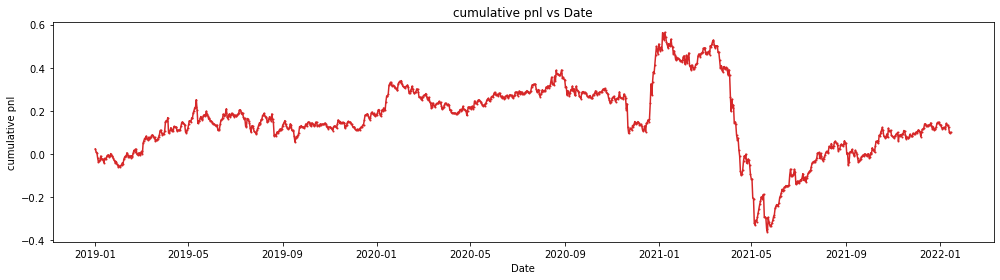

In [224]:
getPnlSummary[signalTbl]